## Generate Text versions of Submission files

You will need to run this notebook cell to convert the submissions into a format usable by the GraderGPT_SP and GraderGPT_MP scripts.

The `rootSubmissionFolder` should contain the unzipped submission folders that are exported from Canvas.

The `textSubmissionsFolder` should ideally just point to `data/Converted Text Submissions` where the files are converted into a format and directory structure as needed for the scripts to run.

In [ ]:
import os
import pypandoc
from pdf2docx  import parse

rootSubmissionFolder = os.path.join('data', 'Submissions')
textSubmissionsFolder = os.path.join('data', 'Converted Text Submissions')
tempFolder = 'temp'

for assignmentFolder in os.listdir(rootSubmissionFolder):
    if '.DS_Store' in assignmentFolder:
        print('Skipping Mac DS_Store folder.')
        continue
    
    assignmentFolderPath = os.path.join(rootSubmissionFolder, assignmentFolder)
    assignmentID = assignmentFolder.split('_')[-1]
    if not os.path.exists(os.path.join(textSubmissionsFolder, assignmentID)):
            os.mkdir(os.path.join(textSubmissionsFolder, assignmentID))

    for submissionFile in os.listdir(assignmentFolderPath):
        submissionFilePath = os.path.join(rootSubmissionFolder, assignmentFolder, submissionFile)
        fileFormat = submissionFile.split('.')[-1].lower()

        if 'LATE' in submissionFile:
            userID = submissionFile.split('_')[2]
        else:
            userID = submissionFile.split('_')[1]

        savedFileName = userID+'.txt'
        savedFilePath = os.path.join(textSubmissionsFolder, assignmentID, savedFileName)
        if os.path.exists(savedFilePath):
            continue
        print(submissionFilePath)
        
        try:
            if fileFormat=='docx':
                output = pypandoc.convert_file(submissionFilePath, 'plain')
            elif fileFormat=='pdf':
                tempFilePath = os.path.join(tempFolder, 'tempFile.docx')
                parse(submissionFilePath, tempFilePath)
                output = pypandoc.convert_file(tempFilePath, 'plain')
        
            if len(output.split('\n')) < 16:
                print('File seems to have no text content in it. Skipping file.')
            else:
                with open(savedFilePath, 'w') as textFile:
                    textFile.write(output)
        except Exception as e:
            print(f'Error in conversion: {e}')
            print('Skipping file.')
            continue

#### Check length of converted submissions to see if any could have been converted incorrectly.

In [ ]:
textSubmissionsFolder = os.path.join('data', 'Converted Text Submissions')
tempFolder = 'temp'
for assignmentID in os.listdir(textSubmissionsFolder):
    if '.DS_Store' in assignmentID:
        print('Skipping Mac DS_Store folder.')
        continue
    
    assignmentFolderPath = os.path.join(textSubmissionsFolder, assignmentID)

    for submissionFile in os.listdir(assignmentFolderPath):
        submissionFilePath = os.path.join(textSubmissionsFolder, assignmentID, submissionFile)
        with open(submissionFilePath) as textFile:
            submission = textFile.readlines()

        if len(submission) < 16:
            print(submissionFilePath)

## Token counting and checking

In [ ]:
from helper import *
import tiktoken

encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

def num_tokens_from_string(string: str, encoding_name='cl100k_base') -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

config = Config()
config.setFromEnv()

# Option to use custom variables here.
# versionControl = 'V1'
# promptVersion = 'P1'
# courseShorthand = 'MOVESCI'

# customConfigParams = {
#                 'Save Name':f'{courseShorthand}-{versionControl}-{promptVersion}', 
#                 'Overwrite Saves': False, 
#                 'Use Custom Desc.': True
#                 }
# config.setSaveDetails(customConfigParams)

config.setSaveDetails()

gradeRubricAssignmentDF = getGRAData(config)

for index, row in gradeRubricAssignmentDF.iterrows():
    fullPrompt = processTokenCount(row, config)
    if fullPrompt:
        tokenCount = num_tokens_from_string(fullPrompt)
        if tokenCount > 8192:
            display(row)


## View & Save Full Prompt to File

In [ ]:
from helper import *

config = Config()
config.setFromEnv()

# Option to use custom variables here.
versionControl = 'V4'
promptVersion = 'P2'
courseShorthand = 'MOVESCI'

customConfigParams = {
                'Save Name':f'{courseShorthand}-{versionControl}-{promptVersion}', 
                'Overwrite Saves': False, 
                'Use Custom Desc.': True
                }
config.setSaveDetails(customConfigParams)

# config.setSaveDetails()

config.saveTemplatePrompt()

gradeRubricAssignmentDF = getGRAData(config)

for index, row in gradeRubricAssignmentDF.iterrows():
    fullPrompt = processTokenCount(row, config)

    if fullPrompt:
        print(fullPrompt)
        with open(os.path.join(config.baseOutputFolder, \
                               config.outputFolders['PROMPT_FILES'], \
                               config.fullName, \
                               f'{config.fullName}_exampleFilledPrompt.txt'), 'w') as textFile:
            textFile.write(fullPrompt)
        break

## Build custom file for manual criterion descriptions

In [ ]:
from helper import *

config = Config()
config.setFromEnv()

gradeRubricAssignmentDF = getGRAData(config)

rubricData = gradeRubricAssignmentDF[['assignment_id', 'rubric_id', 'assignment_title', 'data_rubric']]\
                .drop_duplicates(subset=['assignment_id', 'rubric_id']).sort_values('assignment_id').reset_index(drop=True)

criterionList = []
for index, row in rubricData.iterrows():
    rubricDict = {param: row[param] for param in ['assignment_id', 'rubric_id', 'assignment_title']}
    for criteria in row['data_rubric']:
        criteriaDict = {param: row[param] for param in rubricDict}
        for param in ['id', 'points', 'ratings', 'description', 'long_description']:
            criteriaDict[param] = criteria[param]
        criterionList.append(criteriaDict)

customRubricTemplateDF = pd.DataFrame(criterionList)
customRubricTemplateDF['custom_description'] = None

filePath = os.path.join(config.baseDataFolder, \
                        config.dataFolders['CSV_DATA'], \
                        f'{config.courseName}criterion.csv')

if os.path.exists(filePath):
    print('File already exists. Not overwriting. Change file path to save elsewhere.')
else:
    customRubricTemplateDF.to_csv(filePath, index=False)
    print(f'Saving criterion CSV to {filePath}')

## Copy Prompts to prompts folder
This just copies the prompts from the nested output directrioes into a root 'prompt' folder instead for easier access.

In [ ]:
import shutil
from helper import *

config = Config()

sourceFolder = os.path.join(config.baseOutputFolder, config.outputFolders['PROMPT_FILES'])
destinationFolder = 'prompts' # config.promptFolder

if os.path.exists(destinationFolder):
    shutil.rmtree(destinationFolder)
shutil.copytree(sourceFolder, destinationFolder)

In [65]:
from helper import *

config = Config()
config.setFromEnv()

# Option to use custom variables here.
versionControl = 'V3'
promptVersion = 'P2'
courseShorthand = 'MOVESCI'
versionControl = 'V3'
promptVersion = 'P2'
courseShorthand = 'ECON'

customConfigParams = {
                'Save Name':f'{courseShorthand}-{versionControl}-{promptVersion}', 
                'Overwrite Saves': False, 
                'Use Custom Desc.': False
                }
config.setSaveDetails(customConfigParams)

gradeRubricAssignmentDF = getGRAData(config)

rubricData = gradeRubricAssignmentDF[['assignment_id', 'rubric_id', 'assignment_title', 'data_rubric']]\
                .drop_duplicates(subset=['assignment_id', 'rubric_id']).sort_values('assignment_id').reset_index(drop=True)

criterionList = []
for index, row in rubricData.iterrows():
    rubricDict = {param: row[param] for param in ['assignment_id', 'rubric_id', 'assignment_title']}
    for criteria in row['data_rubric']:
        criteriaDict = {param: row[param] for param in rubricDict}
        for param in ['id', 'points', 'ratings', 'description', 'long_description']:
            criteriaDict[param] = criteria[param]
        criterionList.append(criteriaDict)

customRubricTemplateDF = pd.DataFrame(criterionList)

2023-09-11T13:54:03-0400 INFO [helper.py:505] - All configuration parameters set up successfully.
2023-09-11T13:54:03-0400 WARNING [helper.py:35] - Column "cleaned_description" not found in assignments csv file. No assignment descriptions will be used.
2023-09-11T13:54:03-0400 INFO [helper.py:39] - Found custom assignment submission pointers.


In [38]:
gradeRubricAssignmentDF['assignment_id'].unique()

for index,row in gradeRubricAssignmentDF.iterrows():
    fullCriterionDF = getRowCriterionDF(row, config)
    fullCritText = buildCritPrompt(fullCriterionDF, useCustomDesc=config.customDescMode)
    print(fullCritText)
    break

1. Criterion Title: 'Peer Essays Read', CriterionID: '_4269', Max Points: '6.0', 
Ratings Guide:
	Revision ideas reference two peer essays, reflecting on how this motivates refinements in the writer's own work by including two specific or one general and one specific idea for revision. : 6.0 points
	Revision ideas reference two unique examples from peer essays and include at least one specific or two general ideas for revision. : 5.0 points
	(1, 2, or 3 points) Revision ideas reference one unique example from peer essays or only generally discuss peer essays read, and does not reflect on how this motivates further refinement in the work. : 3.0 points
2. Criterion Title: 'Peer Feedback Received', CriterionID: '_5534', Max Points: '4.0', 
Ratings Guide:
	Revision ideas reference two unique examples from peer feedback, reflecting on how this motivates refinements in the writer's own work. Citing at least two specific or one general and one specific idea for revision. : 4.0 points
	Revisio

In [52]:
resultsDF = convertPicklesToDF('saves', config)
fuse  = resultsDF['assignment_id'].astype(str) + '_' + resultsDF['rubric_id'].astype(str)
fuse.unique()

resultsDF['assignment_id'].unqiue()

,submitter_id,grader_id,rubric_id,assignment_id,score,points_possible,data_peerGPT,peerGPT_score
0,490197,500508,132527,1884801,10.0,10.0,points_grade criterion_id description_grade...,9.0
1,496961,591823,132527,1884801,10.0,10.0,points_grade criterion_id description_grade...,9.0
2,498333,500508,132527,1884801,10.0,10.0,points_grade criterion_id description_grade...,9.0
3,500176,638837,132527,1884801,10.0,10.0,points_grade criterion_id description_grade...,9.0
4,512946,498554,132527,1884801,10.0,10.0,points_grade criterion_id description_grade...,9.0
...,...,...,...,...,...,...,...,...
2015,744444,645104,132529,1884819,52.0,60.0,points_grade criterion_id description_g...,54.0
2016,759019,638837,132529,1884819,52.0,60.0,points_grade criterion_id description_g...,54.0
2017,760828,638837,132529,1884819,50.0,60.0,criterion_id description_grade comments...,56.0
2018,762192,642594,132529,1884819,56.0,60.0,points_grade criterion_id description_g...,50.0


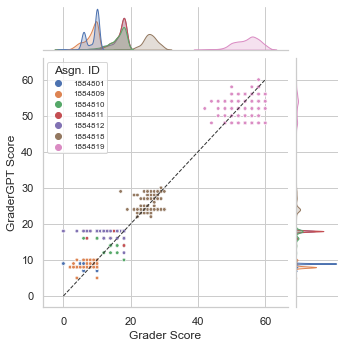

In [66]:
from postProcessHelper import *

resultsDF = convertPicklesToDF('saves', config)

chartFolder = os.path.join(config.baseOutputFolder, \
                           config.outputFolders['CHART_OUTPUT'], \
                           config.fullName)

sns.set_theme(style="whitegrid", palette="deep")

filterDF = resultsDF
maxScore = resultsDF['points_possible'].max()
assgnCount = len(resultsDF['assignment_id'].unique())
sns.jointplot(data=filterDF, x='score', y='peerGPT_score', hue='assignment_id', height=5, marker=".", s=50, palette=sns.color_palette()[:assgnCount])
plt.plot([0,maxScore],[0,maxScore], lw=1, color='#313232', linestyle='dashed')
# plt.plot([1,46],[0,40], lw=1, color='#aaaaaa', linestyle='dashed')
# plt.plot([0,40],[1,46], lw=1, color='#aaaaaa', linestyle='dashed')g.set_xlabel('Grader Score',fontsize=8)
plt.xlabel('Grader Score', fontsize=12)
plt.ylabel('GraderGPT Score', fontsize=12, rotation=90)
plt.legend(title='Asgn. ID', fontsize=8)
# plt.show()
plt.savefig(os.path.join(chartFolder, 'JointPlot.png'), dpi=300, bbox_inches='tight')
# plt.close()



In [61]:
resultsDF = convertPicklesToDF('saves', config)

display(resultsDF.iloc[608])

resultsDF.iloc[608]['data_peerGPT']

submitter_id                                                  738118
grader_id                                                     501274
rubric_id                                                     136366
assignment_id                                                1916709
score                                                           39.0
points_possible                                                 40.0
data_peerGPT          points_grade criterion_id description_grade...
peerGPT_score                                                   31.5
Name: 608, dtype: object

,points_grade,criterion_id,description_grade,comments,description_rubric,points_rubric,custom_description,peerGPT_criterion_id,peerGPT_criterion_score,peerGPT_reason
0,5.0,_5064,Full Marks,Nice job with this.,Summary of study design and main findings of A...,5.0,Independent and Dependent variables need to be...,_5064,3.0,The independent and dependent variables were c...
1,10.0,_8296,Full Marks,Overall good improvement. You do a better job ...,Description of experiment planned,10.0,"Overall study design, dependent and independen...",_8296,8.0,The overall study design was correctly identif...
2,7.0,_1541,No Details,Good improvement! We were also looking for you...,Clear rationale provided for the choice of stu...,8.0,Explain the purpose for the choice of study su...,_1541,6.0,The purpose for the choice of study subjects w...
3,4.0,_9168,Full Marks,Good work defining metabolic cost and explaini...,Understandable to audience,4.0,Make notes about concision and avoiding be rep...,_9168,4.0,The language used was understandable to the au...
4,3.0,_7868,Full Marks,Nice job implementing memo format.,Memo format + appropriate length,3.0,"For draft, do not deduct points\nIf not in mem...",_7868,3.0,The submission was in memo format and was an a...
5,5.0,82499_1929,Full Marks,Great job! Your revisions definitely helped to...,Revision,5.0,If the student revised but didn’t address impo...,82499_1929,5.0,The student made revisions to their submission...
6,5.0,136366_3033,Full Marks,"Excellent work, very insightful!",Reflection,5.0,A summary of at least 150 words that addresses...,136366_3033,2.5,The reflection was only 98 words and did not f...


In [69]:
from helper import *

config = Config()
config.setFromEnv()

config.setSaveDetails()

peerBot = peerGPT(config)
#  response, responseSucess = peerBot.get_completion('What is an interesting fact about the Moon in 20 words or less?')
# display(response)

response = openai.ChatCompletion.create(
                    engine=peerBot.engineName,
                    messages=[{"role": "user", "content": 'What is an interesting fact about the Moon in 20 words or less?'}],
                    temperature=0,
                )
display({'Text':response.choices[0].message["content"], 
         'Tokens':response.usage['total_tokens']})

2023-09-12T10:25:20-0400 INFO [helper.py:505] - All configuration parameters set up successfully.


{'Text': 'The Moon is the fifth largest moon in the solar system and the only natural satellite of Earth.',
 'Tokens': 42}